I gathered the mean distances to all the pulsars in the IPTA dr2, as well as their positions in the sky and the plus and minus error for all their distances just for the heck of it. It's in a text file, hopefully in the same folder as this notebook. Read from the folder. Made a distribution graph of those distances, and I was *hoping* to plot their positions on a sky map and get some insight into how the position of a GW source at various locations in the sky would interact with the distance and location distribution of the pulsars, but I have not gotten the sky map working yet.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import healpy as hp

In [2]:
#a pulsar class so you can create pulsar objects with all that data from the text file so they're easier to work with

class Pulsar:
    def __init__(self, line):
        line = line.split()
        
        self.name = line[0]
        
        temp = line[1].split('+')
        self.meanDistance = float(temp[0])
        temporary = temp[1].split('-')
        self.plusError = float(temporary[0])
        self.minusError = float(temporary[1])
        
        self.rAsc = line[2]
        dividedUp = self.rAsc.split(':')
        hours = float(dividedUp[0])
        minutes = float(dividedUp[1])
        seconds = float(dividedUp[2])
        hours += (minutes / 60) + (seconds / 3600)
        self.phi = np.pi * hours / 12 #THIS IS IN RADIANS
        
        self.dec = line[3]
        divvyUp = self.dec.split(':')
        sign = divvyUp[0][0:1]
        divvyUp[0] = divvyUp[0][1:]
        degrees = float(divvyUp[0])
        minutes = float(divvyUp[1])
        seconds = float(divvyUp[2])
        degrees += (minutes / 60) + (seconds / 3600)
        if (sign.endswith('+')):
            self.theta = (np.pi/2) - (np.pi * degrees / 180)
        else:
            self.theta = (np.pi/2) + (np.pi * degrees / 180)
            
        self.pos = [np.sin(self.phi) * np.cos(self.theta), np.sin(self.phi) * np.sin(self.theta), np.cos(self.phi)]
        
    #can't do multiple constructors? evil evil evil
    
    def __str__(self):
        return str(self.name) + ", located at " + str(self.rAsc) + " " + str(self.dec)+": " + str(self.meanDistance) + "+" + str(self.plusError) + "-" + str(self.minusError) + " kpc"
    

Formula for pos is just the conversion from spherical to Cartesian coordinates (assuming $\rho = 1$, since these are unit vectors):

$$x = \sin{\phi}\cos{\theta}$$
$$y = \sin{\phi}\sin{\theta}$$
$$x = \cos{\phi}$$

This is *similar* to what enterprise does--I'm positive enterprise is converting into Cartesian coordinates (partly just because you need to do that if you want to take the dot product because both polar coordinates and celestial coordinates are not vector spaces and you need to have a vector space if you want an inner product (i.e. a dot product)), but enterprise does it straight from right ascension and declination, not from spherical coordinates, which I don't fully understand. Since I understand this, I'm doing this. I *think* the end result should be the same, but we'll see!

In [3]:
#read from the file
f = open("pulsarDistPM.txt")
pulsars = []
for x in range(65):
    pulsars.append(Pulsar(f.readline()))

7.5


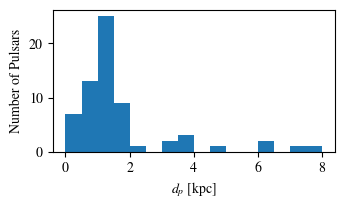

In [14]:
#to make that nice pretty distance distribution plot for the paper

mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

distances = []
for x in range(65):
    distances.append(pulsars[x].meanDistance)
min = 0
bins = []
print(max(distances))
for x in range(17):
    bins.append(min)
    min += 0.5

plt.figure(figsize=figsize(0.5))
plt.hist(distances, bins, histtype='bar', rwidth=1)

plt.xlabel(r'$d_p$ [kpc]', fontsize = 10)
plt.ylabel('Number of Pulsars', fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize = 10)
plt.tight_layout()
plt.savefig("pDist.png", transparent=True)
plt.show()

I was struggling to understand the light travel time function and didn't want to code it until I understood it, so I actually went through quite a few iterations based on different physical models and understandings of the problem. I think this top one is the correct one:

In [6]:
def calcTimeDelay(pDist, pulsarPos, sourcePos):
    return pDist * (1 + np.dot(pulsarPos, sourcePos))

^ Assuming plane wave:
$\Delta = p + p \cos{\mu} = p(1 + \hat{p} \cdot \hat{s})$ where:
- $p$ is the distance from Earth to the pulsar
- $\mu$ is the angle between the unit vectors from Earth to the pulsar and from Earth to the source
- $\hat{p}$ is the unit vector from Earth to the pulsar
- $\hat{s}$ is the unit vector from the Earth to the GW source (take note of the order, opposite of slides)
- $\Delta$ is what I think "light travel time" means

$\Delta t = d_p ( 1 + \hat{p} \cdot \hat{s})$

$\hat{p}$: unit vector from Earth to pulsar
$\hat{s}$: unit vector from Earth to GW source

In [7]:
def distanceTraveledByGW(pDist, sDist, pulsarPos, sourcePos):
    #where sourcePos is the unit vector FROM the source towards us, rather than from US to the source
    #thus, pulsarPos dotted with sourcePos results in -cosMu, not cosMu, which is why below is a plus isntead of a minus
    return pDist + np.sqrt((sDist ** 2) + (pDist ** 2) + (2 * pDist * sDist * np.dot(pulsarPos, sourcePos)))

^ (Assuming spherical wavefronts) From: $\Delta = p + x$ and $x^2 = \Omega^2 + p^2 + 2\Omega p (\hat{\Omega} \cdot \hat{p})$, where:

- $p$ is the distance from Earth to the pulsar
- $\hat{p}$ is the unit vector from Earth to the pulsar
- $\Omega$ is the distance between Earth and the GW source
- $\hat{\Omega}$ is the unit vector from the GW source to Earth (take note of the order, same as slides)
- $x$ is the distance between the pulsar and the GW source
- $\Delta$ is what I *think* the "light travel time" is--the distance traveled by the GW going from the source to the pulsar, and then the distance traveled by the pulsar's signal to Earth

What follows below is something that I guess in theory combined the two? Really should in general just use calcTimeDelay. But this one is nice because it takes in the pulsar object, which contains its distance and position *for* you.

In [8]:
def getLightTravelDistanceForPulsar(pulsar, sourcePos, planeWave, sDist=0):
    """
    :param pulsar: Pulsar object, contains its distance & position (& name)
    :param sourcePos: position vector (in Cartesian coordinates) of the GW source
    :param planeWave: whether we use the plane wave approximation, or if we want to use the spherical wave function
    :param sDist: distance to the GW source, necessary if we want to use the spherical wave function
    """
    #WHAT ARE WE DOING WITH UNITS HOLD UP
    pDist = pulsar.meanDistance
    pulsarPos = pulsar.pos
    if planeWave:
        return calcTimeDelay(pDist, pulsarPos, sourcePos)
    else:
        return distanceTraveledByGW(pDist, sDist, pulsarPos, sourcePos)

My spectacularly failed attempt to plot these pulsars on the sky:

J0023+0923


AttributeError: PathCollection.set() got an unexpected keyword argument 'projection'

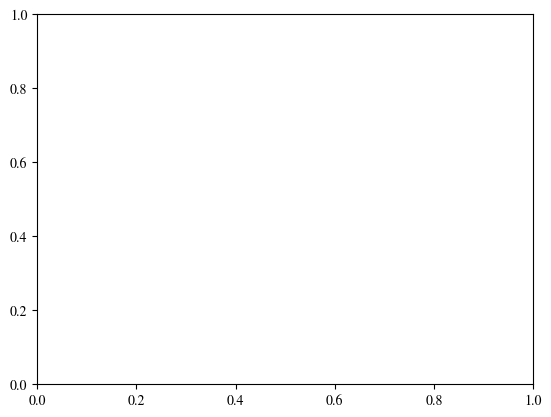

In [15]:

thetas = np.array([])
phis = np.array([])
for x in range(65):
    thetas = np.append(thetas, pulsars[x].theta)
    phis = np.append(phis, pulsars[x].phi)
thetas =  (np.pi / 2) - thetas
phis = phis

#hp.visufunc.mollview(rot=180, title='')


"""fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='mollweide', rot=(180, 0, 0))
"""
#phis = pulsars[0].phi - np.pi
phis = pulsars[0].phi
#thetas = pulsars[0].theta - (np.pi / 2)
thetas = np.pi/2 - pulsars[0].theta
print(pulsars[0].name)
"""

# Plot points
ax.scatter(phis, thetas, s=10, color='black')

# Styling
ax.grid(True)
ax.set_facecolor('white')
ax.set_title("Pulsar Positions (Mollweide Projection)", fontsize=14)

plt.show()"""

plt.scatter(phis, thetas, projection = "mollweide", rot=(180, 0, 0))

Sarah's figsize functions to make pretty golden ratio graphs:

In [9]:
def figsize(scale):
    fig_width_pt = 513.17
    inches_per_pt = 1.0/72.27
    golden_mean = (np.sqrt(5.0)-1.0)/2.0
    fig_width = fig_width_pt * inches_per_pt*scale
    fig_height = fig_width * golden_mean
    fig_size = [fig_width, fig_height]
    
    return fig_size

def figsize2(scale):
    fig_width_pt = 513.17
    inches_per_pt = 1.0/72.27
    golden_mean = (np.sqrt(5.0)-1.0)/2.0
    fig_width = fig_width_pt * inches_per_pt*scale
    fig_height = fig_width * golden_mean
    fig_size = [fig_width, 1.5*fig_height]
    
    return fig_size

def figsize3(scale):
    fig_width_pt = 513.17
    inches_per_pt = 1.0/72.27
    golden_mean = (np.sqrt(5.0)-1.0)/2.0
    fig_width = fig_width_pt * inches_per_pt*scale
    fig_height = fig_width * golden_mean
    fig_size = [fig_width, 2.5*fig_height]
    
    return fig_size